# Training the model

In [ ]:
pip install xgboost

In [ ]:
import pandas as pd
import xgboost as xgb  # Import XGBoost
from sklearn.model_selection import train_test_split  # For splitting dataset
from sklearn.metrics import accuracy_score  # For model evaluation

In [ ]:
df_train= pd.read_csv("/content/preprocessed_train_dataset.csv")

In [ ]:
df_train.columns

Index(['Customer_ID', 'outlet_city', 'luxury_sales', 'fresh_sales',
       'dry_sales', 'cluster_category', 'outliers_luxury', 'outliers_fresh',
       'outliers_dry', 'outlet_city_encoded'],
      dtype='object')

In [ ]:
X = df_train.drop(columns='cluster_category')  # Features (independent variables)
y = df_train['cluster_category']  # Target (dependent variable)

In [ ]:
df_train.drop(columns=['outliers_luxury', 'outliers_fresh', 'outliers_dry','outlet_city' ,'Customer_ID'], inplace=True)

In [ ]:
df_train.columns

Index(['luxury_sales', 'fresh_sales', 'dry_sales', 'cluster_category',
       'outlet_city_encoded'],
      dtype='object')

In [ ]:
# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Convert outlet_city to a categorical type
X_train['outlet_city'] = X_train['outlet_city'].astype('category')
X_test['outlet_city'] = X_test['outlet_city'].astype('category')

In [ ]:
X_train['outlet_city'] = X_train['outlet_city'].cat.codes
X_test['outlet_city'] = X_test['outlet_city'].cat.codes


In [ ]:
y_train = y_train - y_train.min()
y_test = y_test - y_test.min()

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

In [ ]:
# Assuming xgb_model is an instance of XGBClassifier
# Remove the enable_categorical argument to make it compatible with older versions
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Making predictions on test split

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

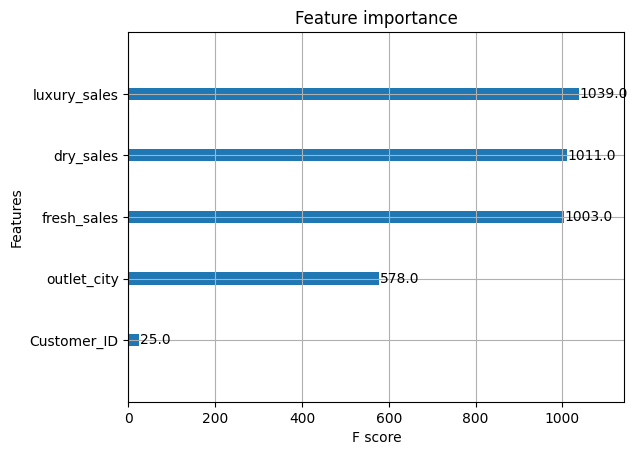

In [ ]:
import xgboost as xgb

# Plot the feature importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)


As per the feature importance plot, we can conclude that 'luxury sales' is the most important feature, meaning it has the greatest influence on the model's predictions.

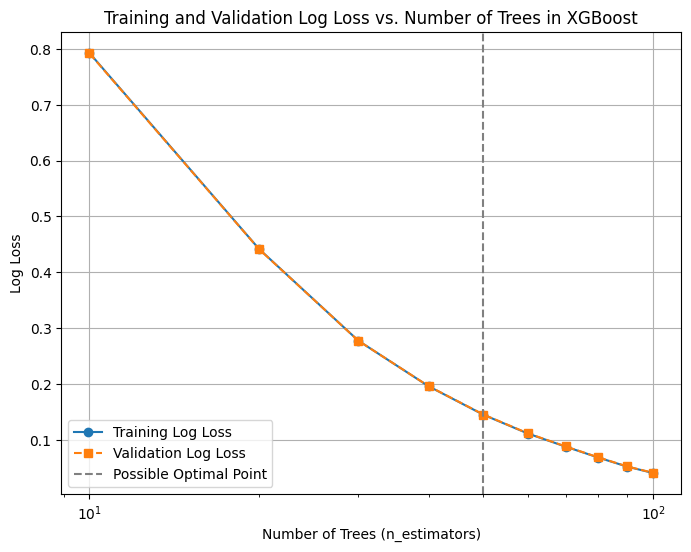

In [ ]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

train_errors = []
val_errors = []

trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for n in trees:
    xgb_model.set_params(n_estimators=n)
    xgb_model.fit(X_train, y_train)

    y_train_proba = xgb_model.predict_proba(X_train)
    y_val_proba = xgb_model.predict_proba(X_test)

    train_errors.append(log_loss(y_train, y_train_proba))
    val_errors.append(log_loss(y_test, y_val_proba))

plt.figure(figsize=(8, 6))
plt.plot(trees, train_errors, label="Training Log Loss", marker='o', linestyle='-')
plt.plot(trees, val_errors, label="Validation Log Loss", marker='s', linestyle='--')

plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Log Loss")
plt.title("Training and Validation Log Loss vs. Number of Trees in XGBoost")
plt.axvline(x=50, color='gray', linestyle='--', label="Possible Optimal Point")
plt.legend()
plt.xscale("log")
plt.grid(True)
plt.show()


In [ ]:
y_pred = xgb_model.predict(X_test)

In [ ]:
#Perform predictions on the test data
y_pred=xgb_model.predict(X_test)


#Create a dataframe for comparing the actual vs predicted results by kNN mode
compare_results_xgb_df = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred})
compare_results_xgb_df

,Actual,Predicted
321727,1,1
211672,1,1
472683,0,0
66176,3,3
344661,4,4
...,...,...
45258,3,3
738978,2,2
180489,1,1
732309,2,2


## Testing the accuracy - before scalling

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9998


In [ ]:
from sklearn.metrics import classification_report
classification_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
classification_report

,precision,recall,f1-score,support
0,0.999921,0.999815,0.999868,37863.000000
1,0.999903,0.999774,0.999839,30989.000000
2,0.998861,0.999793,0.999326,9645.000000
3,0.999710,0.999913,0.999811,34418.000000
4,0.999496,0.999622,0.999559,7934.000000
5,0.999971,0.999706,0.999838,33981.000000
accuracy,0.999793,0.999793,0.999793,0.999793
macro avg,0.999643,0.999770,0.999707,154830.000000
weighted avg,0.999793,0.999793,0.999793,154830.000000


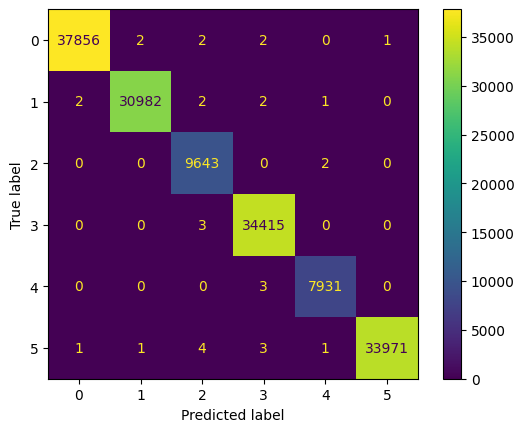

In [ ]:
#Import the packages for costructing the confusion matrix
from sklearn.metrics import confusion_matrix


#Import the packages for plotting the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay


#Costruct the confusion matrix based on…
#comparing actual values (y_test) vs predicted (y_pred) in test data
cm_xgboost = confusion_matrix(y_test, y_pred, labels = xgb_model.classes_)


#Plot the confusion matrix
disp_xgboost_cm = ConfusionMatrixDisplay(cm_xgboost, display_labels=xgb_model.classes_)
disp_xgboost_cm.plot()

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=[f'Class {i}' for i in range(len(cm))], columns=[f'Pred Class {i}' for i in range(len(cm))])

# Display the confusion matrix
print("Confusion Matrix:\n", cm_df)

# Calculate TP, FP, FN, TN for each class
metrics = []

for i in range(len(cm)):
    TP = cm[i, i]  # True Positive: diagonal element
    FP = cm[:, i].sum() - TP  # False Positive: sum of column - TP
    FN = cm[i, :].sum() - TP  # False Negative: sum of row - TP
    TN = cm.sum() - (TP + FP + FN)  # True Negative: total sum - (TP + FP + FN)

    metrics.append({
        'Class': f'Class {i}',
        'True Positive (TP)': TP,
        'False Positive (FP)': FP,
        'False Negative (FN)': FN,
        'True Negative (TN)': TN
    })

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics)
print("\nClass-wise Metrics:\n", metrics_df)


Confusion Matrix:
          Pred Class 0  Pred Class 1  Pred Class 2  Pred Class 3  Pred Class 4  \
Class 0         37856             2             2             2             0   
Class 1             2         30982             2             2             1   
Class 2             0             0          9643             0             2   
Class 3             0             0             3         34415             0   
Class 4             0             0             0             3          7931   
Class 5             1             1             4             3             1   

         Pred Class 5  
Class 0             1  
Class 1             0  
Class 2             0  
Class 3             0  
Class 4             0  
Class 5         33971  

Class-wise Metrics:
      Class  True Positive (TP)  False Positive (FP)  False Negative (FN)  \
0  Class 0               37856                    3                    7   
1  Class 1               30982                    3                    

One vs. Rest ROC curve

<Figure size 800x600 with 0 Axes>

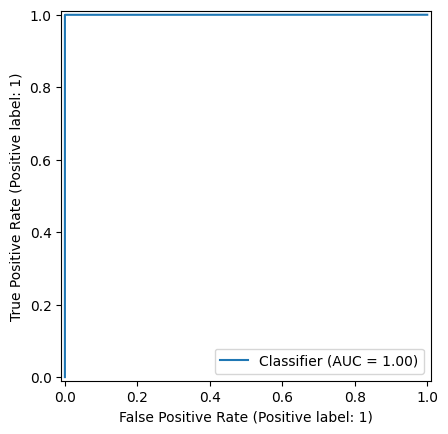

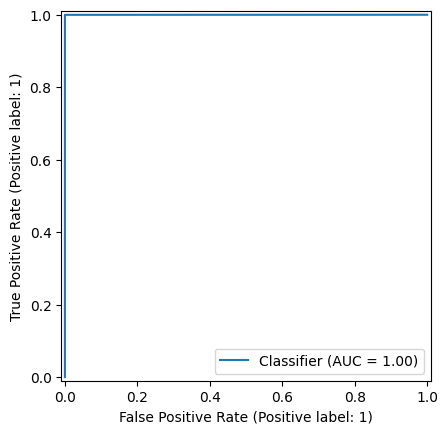

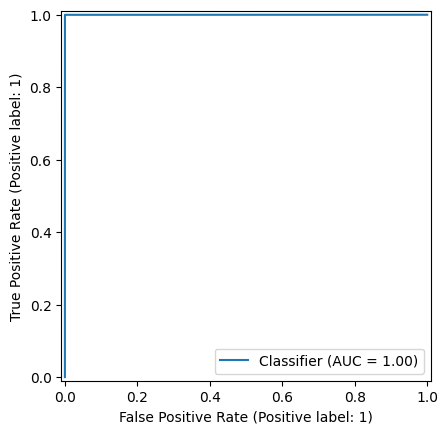

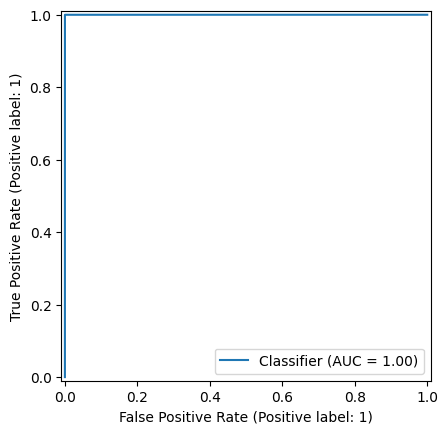

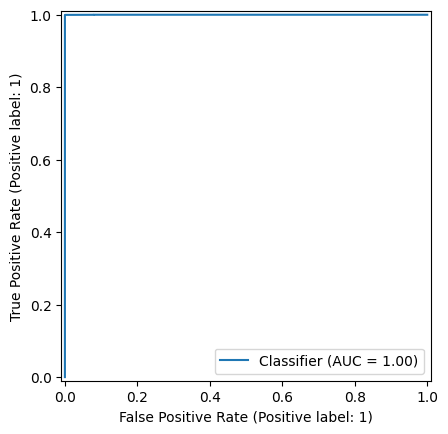

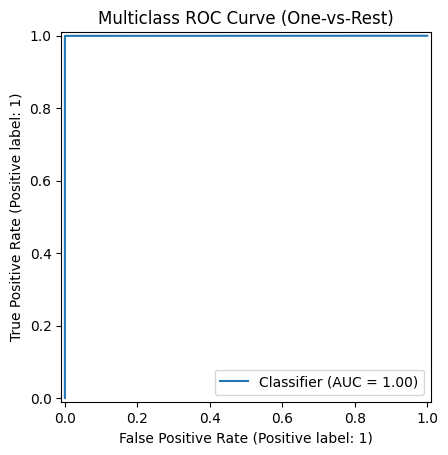

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

# Binarize y_test (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

# Get probability scores for each class
y_score = xgb_model.predict_proba(X_test)

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    RocCurveDisplay.from_predictions(y_test_bin[:, i], y_score[:, i])

plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.show()


## Tesing accuracy - after scalling

In [ ]:
# Identify numerical columns excluding 'luxury_sales' (assuming you don't want to scale this column)
num_cols = X.select_dtypes(include=['number']).columns

### Scaling - RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler

# Initialize the RobustScaler
scaler = RobustScaler()

# Make copies of the train and test sets to avoid modifying original data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Apply scaling to the numerical columns in the train set
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])

# Apply scaling to the numerical columns in the test set (using the same scaling parameters from training data)
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


In [ ]:
# Train the model again on the scaled data
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Make predictions on the scaled test set
y_pred_scaled = xgb_model.predict(X_test_scaled)


In [ ]:
# Calculate accuracy on the scaled data
accuracy_after = accuracy_score(y_test, y_pred_scaled)
print(f"Accuracy after scaling: {accuracy_after:.4f}")

Accuracy after scaling: 0.9998
